# Basic Image classification task

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision
from torchvision import transforms
# other imports
import logging
import warnings
from pathlib import Path

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
# openml.config.start_using_configuration_for_example()
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((16, 16)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
transform_test = Compose(
    [
        transforms.RandomRotation(degrees=5),
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((16, 16)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=32,
    transform=transform,
    transform_test = transform_test
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(363295)


In [4]:
task

OpenML Classification Task
Task Type Description: https://www.openml.org/tt/TaskType.SUPERVISED_CLASSIFICATION
Task ID..............: 363295
Task URL.............: https://www.openml.org/t/363295
Estimation Procedure.: crossvalidation
Evaluation Measure...: predictive_accuracy
Target Feature.......: label
# of Classes.........: 200
Cost Matrix..........: Available

## Model

In [15]:
model = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, len(task.class_labels))

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:
from openml_pytorch.callbacks import Callback
class TestingCallback(Callback):
    """
    Log specific things to TensorBoard.
    - Model
    """

    def __init__(self):
        pass

    def after_epoch(self):
        # print(self.run.recorder.avg_stats.train_stats.__dict__)
        # print(self.run.recorder.avg_stats.valid_stats)
        self.run.loss = 0


class EarlyStoppingCallback(Callback):
    """Stop training when loss stops improving. """
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def after_epoch(self):
        current_loss = self.run.loss
        if self.best_loss is None or current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False

    

In [34]:
import torch


trainer = OpenMLTrainerModule(
    experiment_name= "Testing model upload",
    data_module=data_module,
    verbose=True,
    epoch_count=10,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        # TestCallback,
        TestingCallback,
        EarlyStoppingCallback,
    ],
    opt=torch.optim.Adam,
    loss_fn = torch.nn.CrossEntropyLoss
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

Cross validation 0 for task 363295



Epoch 0
----------------------------------------
Train: train loss: 5.4260 | accuracy: 0.0090 | other metrics: []
Valid: valid loss: 5.3457 | accuracy: 0.0167 | other metrics: []




Epoch 1
----------------------------------------
Train: train loss: 5.0280 | accuracy: 0.0414 | other metrics: []
Valid: valid loss: 5.1247 | accuracy: 0.0361 | other metrics: []




Epoch 2
----------------------------------------
Train: train loss: 4.6183 | accuracy: 0.0784 | other metrics: []
Valid: valid loss: 5.0865 | accuracy: 0.0444 | other metrics: []




Epoch 3
----------------------------------------
Train: train loss: 4.0060 | accuracy: 0.1590 | other metrics: []
Valid: valid loss: 4.9630 | accuracy: 0.0417 | other metrics: []

Early stopping triggered.


KeyboardInterrupt: 

In [ ]:
openml.config.apikey = ""

No metrics recorded.
Error adding metrics to run: [Errno 2] No such file or directory: 'metrics.png'


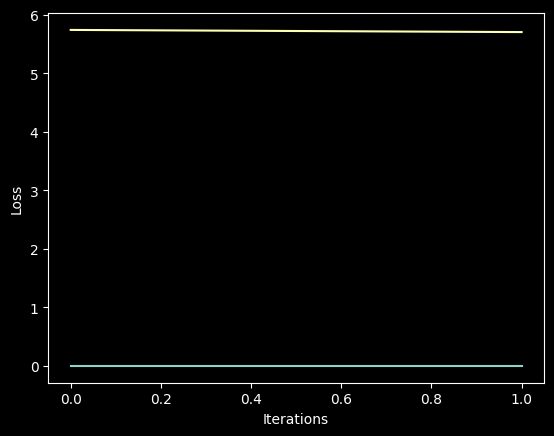

In [8]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer, upload_model=True)

In [9]:
run.publish()

While models of this type are not officially supported, we will try to serialize them anyway.
While models of this type are not officially supported, we will try to serialize them anyway.
While models of this type are not officially supported, we will try to serialize them anyway.
While models of this type are not officially supported, we will try to serialize them anyway.
While models of this type are not officially supported, we will try to serialize them anyway.


OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.0073 +- 0.0041
Run ID..........................: 10595313
Run URL.........................: https://www.openml.org/r/10595313
Task ID.........................: 363295
Task Type.......................: None
Task URL........................: https://www.openml.org/t/363295
Flow ID.........................: 32558
Flow Name.......................: torch.nn.TransformerCompatibility.8c52bf3d52b90e7a
Flow URL........................: https://www.openml.org/f/32558
Setup ID........................: None
Setup String....................: Python_3.13.2. Torch_2.6.0. NumPy_2.2.4. SciPy_1.15.2. TransformerCompatibility(
  (model): ResNetForImageClassification(
    (resnet): ResNetModel(
      (embedder): ResNetEmbeddings(
        (embedder): ResNetConvLayer(
          (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norma

In [11]:
trainer.stats.metrics

{}

In [12]:
trainer.plot_all_metrics()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

<module 'matplotlib.pyplot' from '/Users/smukherjee/Documents/CODE/Github/OpenML/openml-pytorch/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

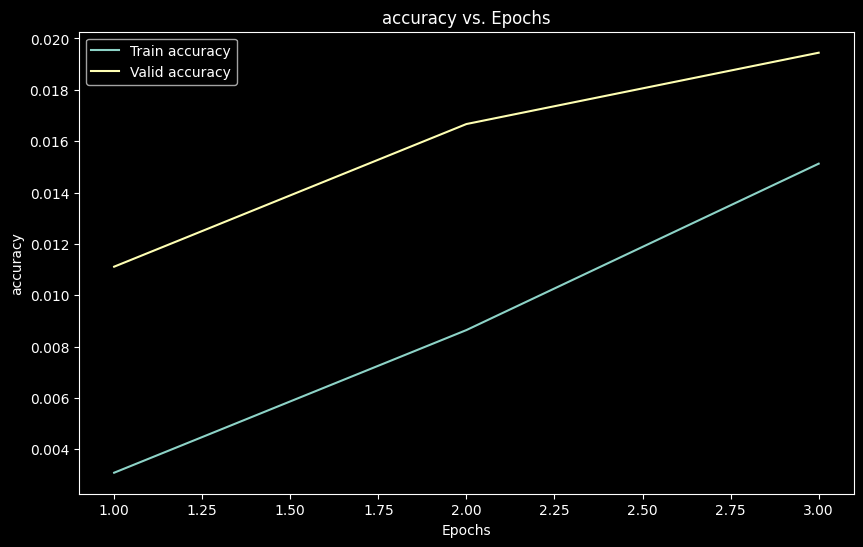

In [9]:
trainer.runner.cbs[1].plot_metric('accuracy')

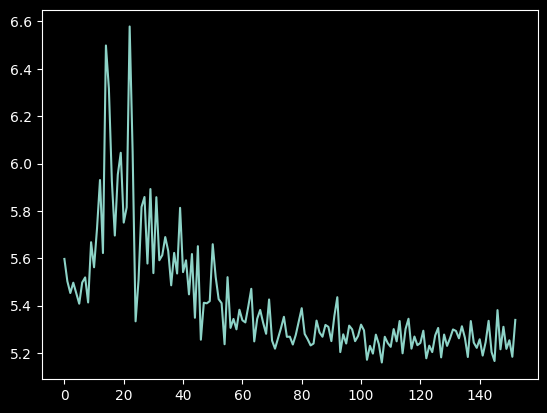

In [13]:
trainer.plot_loss()

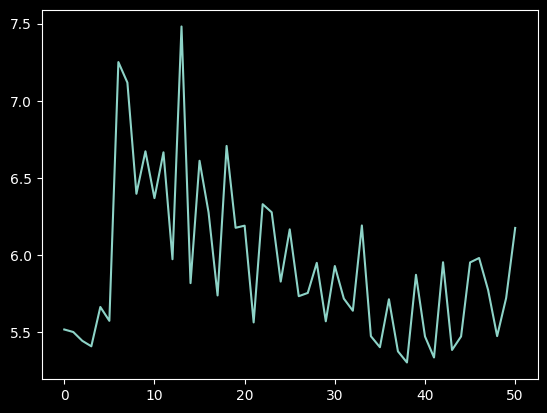

In [22]:
trainer.plot_loss()

## testing push


In [9]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer)

In [ ]:
run.publish()

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

In [ ]:
trainer.cbfs

In [ ]:
trainer.experiment_name

In [ ]:
trainer.model

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
run.publish()

# Pretrained Transformer Image Classification Task

In [ ]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [ ]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [ ]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [ ]:
# Example model. You can do better :)
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Choose a custom Optimizer
- If you want to use a custom optimizer, you can do so by defining the optimizer in the `optimizer` variable.

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [4]:
model = torchvision.models.resnet18(num_classes=200)

## Train your model on the data
- Choose a custom optimizer by defining the optimizer variable.
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [5]:
import torch
from torch.optim import Adam, Optimizer
from openml_pytorch.trainer import OpenMLTask

def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> Optimizer:
    # replace the optimizer with your own
    return Adam(model.fc.parameters())


In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
    optimizer = custom_optimizer_gen,
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Sequential Classification Task
- Sequential classification of a tabular MNIST dataset (Task 3573) using a simple neural network.

In [4]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [5]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    filename_col="class",
    target_mode="categorical",
)

# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

## Model

In [6]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "MNIST",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Tabular classification
- Supervised credit-g classification

In [19]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [20]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    target_column="class",
    target_mode="categorical",
)

# supervised credit-g classification
task = openml.tasks.get_task(31)


## Model

In [21]:
class TabularClassificationmodel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularClassificationmodel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
model = TabularClassificationmodel(20, 2)

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Credit-G",
    data_module=data_module,
    verbose=True,
    epoch_count=5,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()